<a href="https://colab.research.google.com/github/toast210/PCOS-detection/blob/main/pcosshap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this I will use SHAP and Lime

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Model loaded successfully


Saving ultarsound1.jpg to ultarsound1.jpg
Prediction: PCOS
Probabilities: {'Non-PCOS': 4.671855549531756e-06, 'PCOS': 0.9999953508377075}


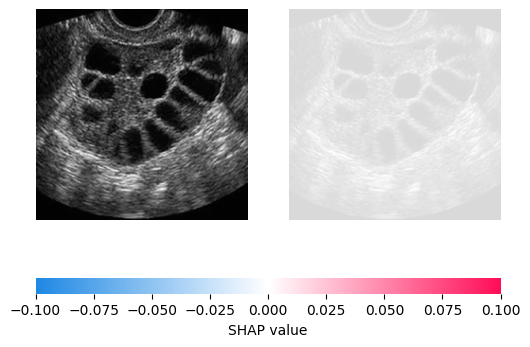

In [ ]:
!pip install shap
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import shap
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from PIL import Image
from google.colab import files


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=False)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)
model.load_state_dict(torch.load("pcos_model.pth", map_location=DEVICE))
model.eval().to(DEVICE)

print(" Model loaded successfully")


transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


uploaded = files.upload()
img_path = list(uploaded.keys())[0]

img = Image.open(img_path).convert("RGB")
img_t = transform(img).unsqueeze(0).to(DEVICE)


with torch.no_grad():
    outputs = model(img_t)
    probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]

print("Prediction:", "PCOS" if probs[1] < probs[0] else "Non-PCOS")
print("Probabilities:", {"Non-PCOS": float(probs[1]), "PCOS": float(probs[0])})


background = img_t.repeat(3, 1, 1, 1)

explainer = shap.GradientExplainer(model, background)
shap_values, indexes = explainer.shap_values(img_t, ranked_outputs=1)

img_np = img_t.squeeze().permute(1, 2, 0).detach().cpu().numpy()

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_disp = std * img_np + mean
img_disp = np.clip(img_disp, 0, 1)

shap.image_plot([shap_values[0]], np.expand_dims(img_disp, axis=0))
plt.show()

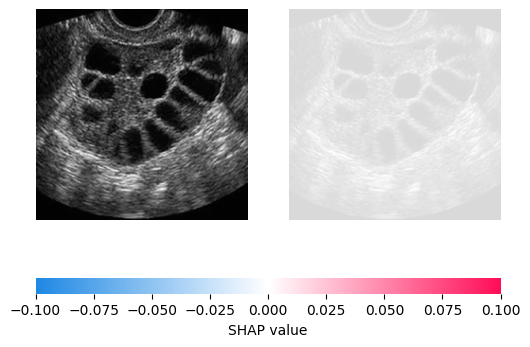

In [ ]:
IMG_SHAP = shap.image_plot([shap_values[0]], np.expand_dims(img_disp, axis=0))

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d392028728e9b39d776732ebd3fd16c94a7ffacfba3bf3040c92fa0f40a59462
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=False)
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)
model.load_state_dict(torch.load("pcos_model.pth", map_location=DEVICE))
model.eval().to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(DEVICE)
    return img, img_t

In [ ]:
def batch_predict(images):
    model.eval()
    batch = torch.stack([transform(Image.fromarray(img)).to(DEVICE) for img in images], dim=0)
    with torch.no_grad():
        logits = model(batch)
        probs = torch.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

  0%|          | 0/1000 [00:00<?, ?it/s]

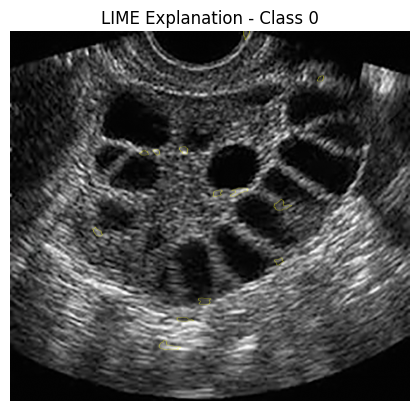

In [ ]:
img_path = "/content/ultarsound1.jpg"
img, img_t = preprocess_image(img_path)


explainer = lime_image.LimeImageExplainer()


explanation = explainer.explain_instance(
    np.array(img),
    batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)


pred_class = np.argmax(batch_predict([np.array(img)])[0])


temp, mask = explanation.get_image_and_mask(
    pred_class,
    positive_only=True,
    num_features=13,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"LIME Explanation - Class {pred_class}")
plt.axis("off")
plt.show()
